## 2018 Data Sciene Bowl

In [123]:
##imports

import os
import sys
import warnings
import gc
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, Sequential, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from keras.optimizers import Adam


seed =1987

random.seed = seed
np.random.seed = seed

In [22]:
IMG_HEIGHT  = 128
IMG_WIDTH   = 128
IMG_CHANNEL = 3 ## 1 for Black and White
TRAIN_PATH = './stage1_train'
TEST_PATH = './stage1_test'

In [23]:
gc.collect()

24

In [69]:
##Collect our file names for training and test date

train_idx =  next(os.walk(TRAIN_PATH))[1]
test_idx  =  next(os.walk(TEST_PATH))[1]

In [77]:
##Creating our image masks of dimension 128 x 128 (black images)
def get_train_data(train_idx,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL,PATH=TRAIN_PATH ):
    '''
    Get train images and masks
    '''

    print('Fetching and resizing train images')
    ## If you have less RAM try splitting it in batches
    X_train = np.zeros((len(train_idx),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL ),dtype =np.uint8)
    ## Mask has only 1 channel
    y_train = np.zeros((len(train_idx),IMG_HEIGHT,IMG_WIDTH,1 ),dtype=np.bool)

    # Re-sizing our training images to 128 x 128
    for i,idx in tqdm_notebook(enumerate(train_idx), total = len(train_idx)):
        path = os.path.join(PATH , idx,'images') + '/'+idx +'.png'
        img  = imread(path)[:,:,:IMG_CHANNEL]
        img  = resize(img, (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL), mode = 'constant', preserve_range=True)
        X_train[i] = img
        ##mask
        mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,1 ),dtype =np.uint8)
        for mask_file in  next(os.walk(os.path.join(PATH ,idx,'masks')))[2]:
            mask_1_img = imread(os.path.join(PATH , idx,'masks', mask_file))
            
            mask_1_img = resize(mask_1_img, (IMG_HEIGHT,IMG_WIDTH), mode = 'constant', preserve_range=True)
            mask_1_img = np.expand_dims(mask_1_img, axis =-1)
            ##print(mask_1_img.shape)
            ## Here the background is 0(black) and frontcolor is nonzero..So we are using np.maximum
            mask = np.maximum(mask,mask_1_img )
        y_train[i] = mask
        
    return X_train,y_train


def get_test_data(test_idx,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL,PATH= TEST_PATH):
    '''
    Get test images
    '''    
    print('Fetching and resizing test images')
    ## If you have less RAM try splitting it in batches
    X_test = np.zeros((len(test_idx),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL ),dtype =np.uint8)

    # Re-sizing our training images to 128 x 128
    for i,idx in tqdm_notebook(enumerate(test_idx), total = len(test_idx)):
        path = os.path.join(PATH , idx,'images') +  '/'+ idx +'.png'
        img  = imread(path)
        img  = resize(img, (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL), mode = 'constant', preserve_range=True)
        X_test[i] = img    
    return X_test

X_train,y_train = get_train_data(train_idx,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL,PATH=TRAIN_PATH )
## Test
X_test= get_test_data(test_idx,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL,TEST_PATH)

Fetching and resizing train images


Fetching and resizing test images


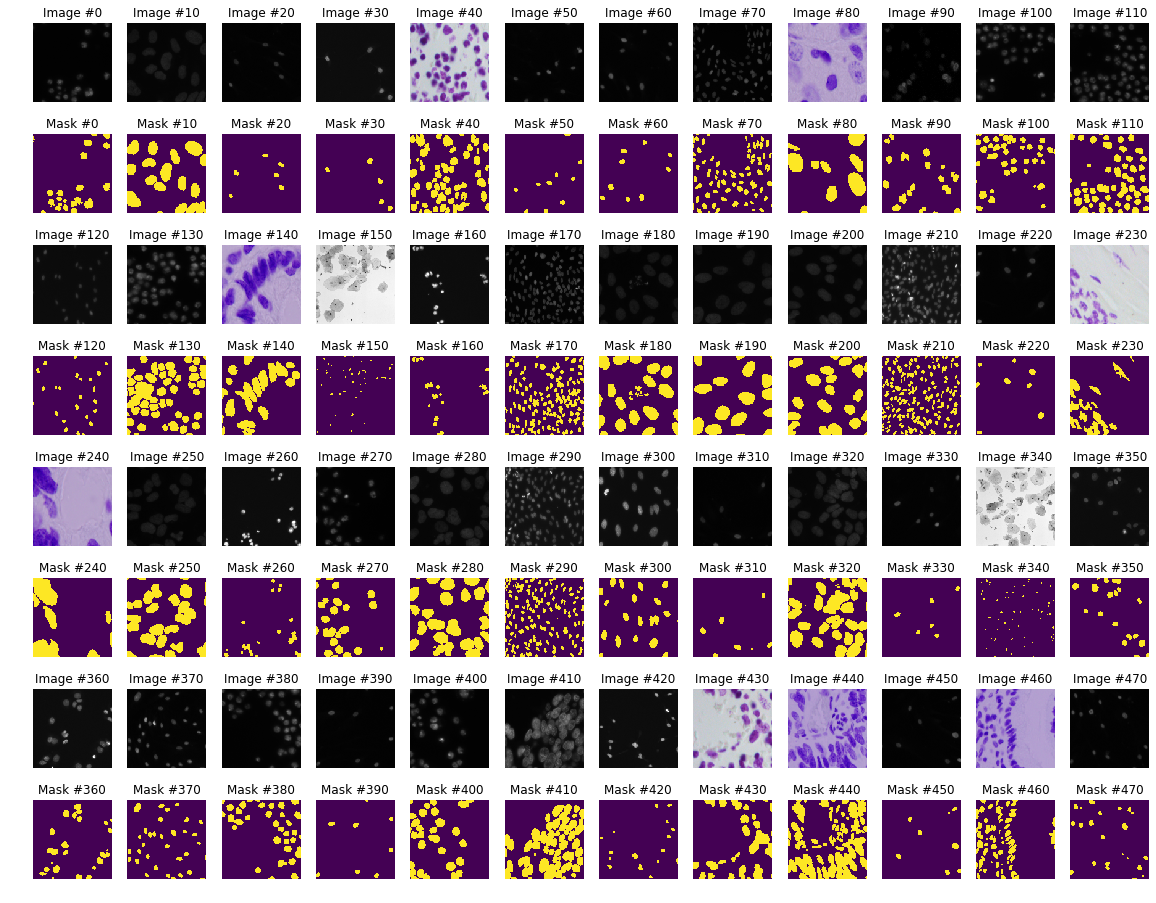

In [78]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [89]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [90]:
# Alternative IoU function

def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

In [91]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

##### U-Net Model

In [124]:
inputs = Input((IMG_HEIGHT,IMG_WIDTH, IMG_CHANNEL))

s  = Lambda(lambda x : x/255)(inputs) ## Normalize the images
c1 = Conv2D(16, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3),activation = 'elu', kernel_initializer='he_normal', padding='same')(c5)
##p5 = MaxPooling2D(c5) NO maxpooling in bottleneck

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
####
# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs = [inputs],outputs = [outputs])
optimizer = Adam(lr = .001)

model.compile(optimizer =optimizer, loss= 'binary_crossentropy', metrics = [my_iou_metric])

In [125]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 128, 128, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 128, 128, 16) 448         lambda_12[0][0]                  
__________________________________________________________________________________________________
dropout_84 (Dropout)            (None, 128, 128, 16) 0           conv2d_176[0][0]                 
__________________________________________________________________________________________________
conv2d_177

__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 128, 128, 16) 4624        concatenate_40[0][0]             
__________________________________________________________________________________________________
dropout_92 (Dropout)            (None, 128, 128, 16) 0           conv2d_192[0][0]                 
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 128, 128, 16) 2320        dropout_92[0][0]                 
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 128, 128, 1)  17          conv2d_193[0][0]                 
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [126]:
model_path = './dsc2018_best.h5'

checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=2)

reducelr = ReduceLROnPlateau(factor= 0.4, patience = 3, monitor="val_loss",mode="min")

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 2,
                          restore_best_weights = True)

results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=30, verbose =2 ,
                    callbacks=[earlystop, checkpoint,reducelr])


Train on 603 samples, validate on 67 samples
Epoch 1/30
 - 6s - loss: 0.3520 - my_iou_metric: 0.0078 - val_loss: 0.1005 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.10055, saving model to ./dsc2018_best.h5
Epoch 2/30
 - 3s - loss: 0.1960 - my_iou_metric: 0.1130 - val_loss: 0.2494 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.10055
Epoch 3/30
 - 3s - loss: 0.1700 - my_iou_metric: 0.2094 - val_loss: 0.1726 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.10055
Epoch 4/30
 - 3s - loss: 0.1534 - my_iou_metric: 0.2537 - val_loss: 0.2758 - val_my_iou_metric: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.10055
Epoch 5/30
 - 3s - loss: 0.1406 - my_iou_metric: 0.3062 - val_loss: 0.2235 - val_my_iou_metric: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.10055
Epoch 6/30
 - 3s - loss: 0.1362 - my_iou_metric: 0.3131 - val_loss: 0.2591 - val_my_iou_metric: 0.0000e+00

Epoch 00006: val_

In [127]:
##Generating our predictions for training and validation data

In [128]:
# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - ETA:  - 0s 1ms/step


In [ ]:
## Showing our predicted masks on our training data

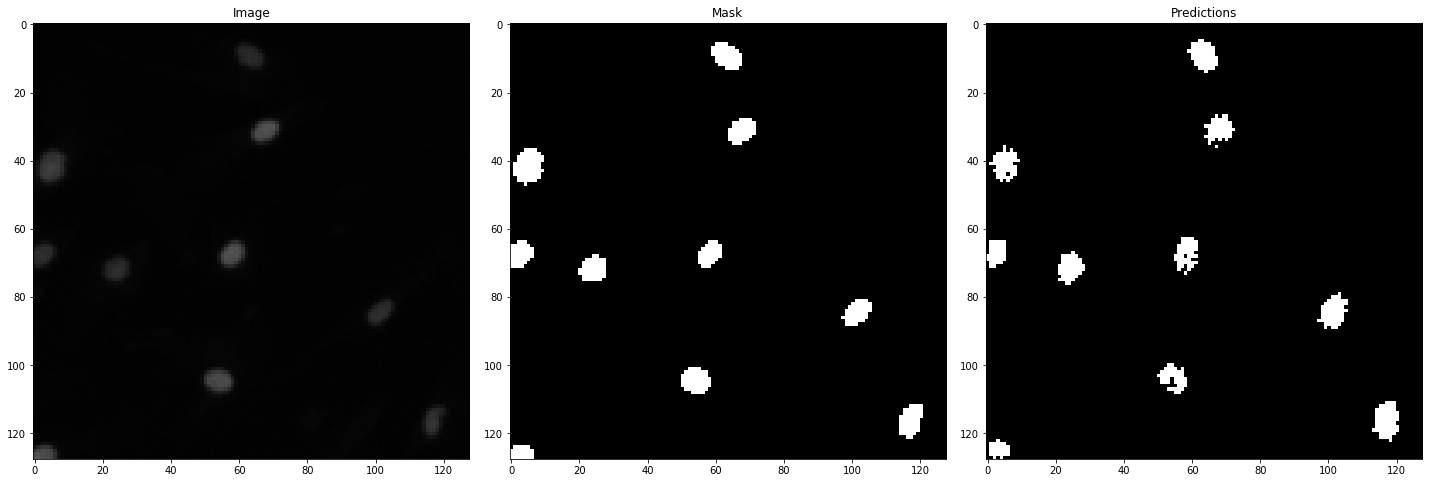

In [129]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()